In [1]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import re
import os
import seaborn
import matplotlib.pyplot as plt

from keras import backend as K
from keras.utils import np_utils
from keras.models import Sequential
import keras.layers as layers
from keras.layers import Dense, Dropout, LSTM, Embedding, Input, RepeatVector
from keras.optimizers import SGD
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras.engine import Layer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize.treebank import TreebankWordDetokenizer

%matplotlib inline

print(tf.VERSION)
print(tf.keras.__version__)

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

1.14.0
2.2.4-tf


In [2]:
# tests to see if gpu is working
# sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

with tf.Session() as sess:
    devices = sess.list_devices()
    print(devices)

with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 9371607073326031485), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 15935754859020216855), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_GPU:1, XLA_GPU, 17179869184, 1265569899953759313), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 3031668525000473917), _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 208863232, 16896926859332849371), _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:1, GPU, 11154794087, 4065665577044160829)]
[[22. 28.]
 [49. 64.]]


In [3]:
# test tensorflow hub elmo module

elmo = hub.Module("module/module_elmo2/", trainable=True)
sentence_input = ["the cat is on the mat", "what are you doing in evening"]

word_embeddings = elmo(
    inputs = sentence_input, 
    signature = "default",
    as_dict = True)["word_emb"]

lstm1_embeddings = elmo(
    inputs = sentence_input, 
    signature = "default",
    as_dict = True)["lstm_outputs1"]

lstm2_embeddings = elmo(
    inputs = sentence_input, 
    signature = "default",
    as_dict = True)["lstm_outputs2"]

elmo_embeddings = elmo(
    inputs = sentence_input, 
    signature = "default",
    as_dict = True)["elmo"]

default_embeddings = elmo(
    inputs = sentence_input, 
    signature = "default",
    as_dict = True)["default"]


print(word_embeddings)
print(lstm1_embeddings)
print(lstm2_embeddings)
print(elmo_embeddings)
print(default_embeddings)


Tensor("module_apply_default/bilm/Reshape_1:0", shape=(2, 6, 512), dtype=float32)
Tensor("module_apply_default_1/concat:0", shape=(2, ?, 1024), dtype=float32)
Tensor("module_apply_default_2/concat_1:0", shape=(2, ?, 1024), dtype=float32)
Tensor("module_apply_default_3/aggregation/mul_3:0", shape=(2, 6, 1024), dtype=float32)
Tensor("module_apply_default_4/truediv:0", shape=(2, 1024), dtype=float32)


In [4]:
# load full/subset of the FNC dataset

data = pd.read_csv("FNC_Final.csv", engine = "python",error_bad_lines=False)
# data = pd.read_csv("FNC_Subset.csv")
data.head()


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,id,domain,type,url,content,scraped_at,inserted_at,...,summary,source,len_content,len_title,num_exclaim_title,num_sentences_content,sentences_content,num_paras,num_punc_content,percent_punc_content_per_len
0,2,2,114,138,coed.com,fake,https://coed.com/2018/01/23/boston-celtics-vs-...,VIEW GALLERY\n\nThe Boston Celtics are traveli...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,...,NaN,NaN,694,7,0,31,['VIEW GALLERY\n\nThe Boston Celtics are trave...,37,149,21.469741
1,3,3,150,176,beforeitsnews.com,fake,http://beforeitsnews.com/prophecy/2018/01/the-...,The Truth About the Israel-Palestine Conflict\...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,...,NaN,NaN,2663,6,0,102,['The Truth About the Israel-Palestine Conflic...,165,565,21.216673
2,6,6,345,408,betootaadvocate.com,satire,http://www.betootaadvocate.com/humans-of-betoo...,ERROL PARKER | Editor-at-large | Contact\n\n“H...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,...,NaN,NaN,406,11,0,29,['ERROL PARKER | Editor-at-large | Contact\n\n...,43,141,34.729064
3,7,7,369,433,beehivebugle.com,satire,http://beehivebugle.com/2013/11/18/american-fo...,American Fork’s East 17th Ward’s excitement er...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,...,NaN,NaN,459,11,0,25,['American Fork’s East 17th Ward’s excitement ...,15,113,24.618736
4,12,12,603,685,beforeitsnews.com,fake,http://beforeitsnews.com/watercooler-topics/20...,Hobby Historian Claims to Have Discovered Forg...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,...,NaN,NaN,172,13,0,9,['Hobby Historian Claims to Have Discovered Fo...,11,62,36.046512


In [5]:
# examine summary stats for 'type' column

print(data.shape)
print(data['type'].describe())
print(data['type'].unique())

data['type'].fillna('unknown',inplace = True)
print(data['type'].describe())
print(data['type'].unique())

(142395, 27)
count       142395
unique           5
top       reliable
freq         47753
Name: type, dtype: object
['fake' 'satire' 'reliable' 'political' 'bias']
count       142395
unique           5
top       reliable
freq         47753
Name: type, dtype: object
['fake' 'satire' 'reliable' 'political' 'bias']


In [6]:
# Remove articles from survey

survey_articles= pd.read_csv('survey_articles.csv')
survey_list= list(survey_articles['id'])
to_delete= list(data[data.id.isin(survey_list)].index)
data[data.id.isin(survey_list)]

# Remove articles from survey
data=data.drop(to_delete,axis=0)
data[data.id.isin(survey_list)]

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,id,domain,type,url,content,scraped_at,inserted_at,...,summary,source,len_content,len_title,num_exclaim_title,num_sentences_content,sentences_content,num_paras,num_punc_content,percent_punc_content_per_len


In [7]:
# examine reliable, satire, fake, etc. articles

reliable = data.loc[data['type'] == 'reliable']
satire = data.loc[data['type'] == 'satire']
fake = data.loc[data['type'] == 'fake']
political = data.loc[data['type'] == 'political']
bias = data.loc[data['type'] == 'bias']

print(type(reliable['type']))
print(len(reliable['type']))
print(type(fake['type']))
print(len(fake['type']))

print(len(satire['type']))
print(len(political['type']))
print(len(bias['type']))

<class 'pandas.core.series.Series'>
47753
<class 'pandas.core.series.Series'>
22280
2863
41166
28332


In [8]:
# select random sample from reliable, fake, etc, then combine in a new dataframe

fake = fake.sample(n=10000)
reliable = reliable.sample(n=10000)
satire = satire.sample (n=2863)
political = political.sample(n=10000)
bias = bias.sample(n=10000)
# print(type(fake))
# print(fake.head())

data = reliable.append(fake)
data = data.append(satire)
data = data.append(political)
data = data.append(bias)

# shuffle the new dataset
data = data.sample(frac=1).reset_index(drop=True)

data.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,id,domain,type,url,content,scraped_at,inserted_at,...,summary,source,len_content,len_title,num_exclaim_title,num_sentences_content,sentences_content,num_paras,num_punc_content,percent_punc_content_per_len
0,206654,206654,2547,9651885,nytimes.com,reliable,https://www.nytimes.com/2014/07/16/realestate/...,Q. So you do what specifically?\n\nA. We revie...,2018-02-11 00:47:37.281256,2018-02-11 00:14:20.346838,...,NaN,nytimes,548,3,0,70,"['Q.', 'So you do what specifically?', 'A.', '...",55,174,31.751825
1,11786,11786,1691,535837,dailykos.com,political,https://www.dailykos.com/stories/2006/10/9/255...,Here's what Matt was reacting to:\n\nAfter 1 a...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,...,NaN,NaN,419,7,0,34,"[""Here's what Matt was reacting to:\n\nAfter 1...",45,203,48.448687
2,77182,77182,7190,3615091,beforeitsnews.com,fake,http://beforeitsnews.com/opinion/2014/01/a-chi...,(Before It's News)\n\nThehas published a fasci...,2017-11-21T12:56:35.440396,2018-02-07 23:39:33.852671,...,NaN,NaN,572,6,0,25,"[""(Before It's News)\n\nThehas published a fas...",35,148,25.874126
3,50513,50513,2934,2335268,dailykos.com,political,https://www.dailykos.com/stories/2016/11/18/16...,"A few days back I posted this diary, which rec...",2017-11-10T11:18:44.524042,2018-02-07 23:39:33.852671,...,NaN,NaN,872,6,0,59,"['A few days back I posted this diary, which r...",61,349,40.022936
4,117659,117659,7792,5498904,rawstory.com,political,https://www.rawstory.com/2013/04/top-french-ga...,"One of France’s most dangerous gangsters, know...",2017-11-27T01:15:02.476695,2018-02-08 19:18:34.468038,...,NaN,NaN,480,7,0,24,"['One of France’s most dangerous gangsters, kn...",39,119,24.791667


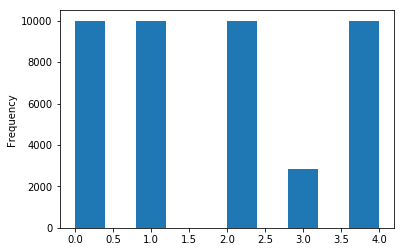

In [9]:
# change "reliable", "satire", "fake", etc. to 0,1,2,etc.

data.loc[data['type'] == 'reliable', 'type'] = 0.0
data.loc[data['type'] == 'political', 'type'] = 1.0
data.loc[data['type'] == 'bias', 'type'] = 2.0
data.loc[data['type'] == 'satire', 'type'] = 3.0
data.loc[data['type'] == 'fake', 'type'] = 4.0
data['content'] = data['title']+'\n'+data['content']

# plot the distribution,
data['type'].plot.hist()


In [10]:
# split data into train and test

msk = np.random.rand(len(data)) < 0.7

train = data[msk]
validation = data[~msk]

msk2 = np.random.rand(len(validation)) < 0.7

val = validation[msk2]
test = validation[~msk2]

train_data = train[['content','type']].copy()
val_data = val[['content','type']].copy()
test_data = test[['content','type']].copy()

print(len(train_data))
print(len(val_data))
print(len(test_data))

30070
8920
3873


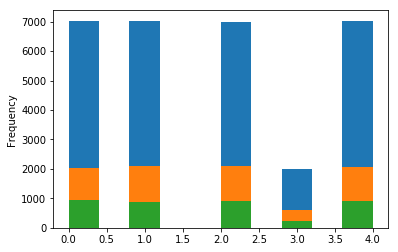

In [11]:
# plot the distribution of train_data
train_data['type'].plot.hist()

# plot the distribution of val_data
val_data['type'].plot.hist()

# plot the distribution of test_data
test_data['type'].plot.hist()

In [12]:
def cleanText(text):
    #remove EOL 
    text = str(text).strip().replace("\n", " ").replace("\r", " ")
    text= text.split(" ")
    
    #remove stop words 
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    arr= np.array(text)
    # preprocess data to standardize lengths
    #text= text[0:999]
        
    #text=' '.join(text)
    
#     text = replace_contraction(text)
#     text = replace_links(text, "link")
#     text = remove_numbers(text)
#     text = re.sub(r'[,!@#$%^&*)(|/><";:.?\'\\}{]',"",text)
#     text = text.lower()
    return arr

In [13]:
# remove EOL, stopwords

x_train = np.array(train_data["content"].apply(cleanText))
y_train = np.array(train_data["type"])

x_val = np.array(val_data["content"].apply(cleanText))
y_val = np.array(val_data["type"])

x_test = np.array(test_data["content"].apply(cleanText))
y_test = np.array(test_data["type"])
    
print(x_train[0])
print(y_train)
print(type(y_train))

['Robert' 'W.' 'Barone' 'Q.' 'So' 'specifically?' '' 'A.' 'We' 'review'
 'drawings,' 'contracts,' 'budgets,' 'well' 'permits' 'schedules,'
 'determine' 'based' 'upon' 'completion' 'quality' 'documents' 'risks'
 'related' 'client' 'going' 'forward.' '' 'Q.' 'What' 'environmental'
 'issues' 'might' 'encounter?' '' 'A.' 'Our' 'firm' 'conducting' 'Phase'
 'I' 'assessments' 'since' 'late' '’80s.' 'There' 'generally' 'many'
 'surprises.' 'Some' 'biggest' 'problems' 'land' 'development' 'dry'
 'cleaners,' 'gas' 'stations,' 'ways' 'handle' 'that.' '' 'Q.' 'Are'
 'ever' 'instances' 'concluded' 'something' 'good' 'deal?' '' 'A.' 'Yes.'
 'I' 'wouldn’t' 'say' 'many,' 'instances,' 'usually' 'ways' 'solve' 'it.'
 'It’s' 'creative.' '' 'Q.' 'How' 'so?' '' 'A.' 'One' 'biggest' 'problems'
 'right' 'speed' 'developers' 'trying' 'move' 'forward' 'with.' 'And'
 'speed' 'incompleteness' 'documents' 'comes' 'higher' 'risk.' 'We' 'take'
 'look' 'completion' 'documents,' 'may' 'suggest' 'little' 'money' 'set'

In [14]:
# pad the sequences
x_train = pad_sequences(x_train, value= "PAD", dtype=object, padding= 'post', truncating = 'post', maxlen=128)
x_val = pad_sequences(x_val, value= "PAD", dtype=object, padding= 'post', truncating = 'post', maxlen=128)
x_test = pad_sequences(x_test, value= "PAD", dtype=object, padding= 'post', truncating = 'post', maxlen=128)

print(len(x_train[1]))
print(len(x_train))
print(x_train[1])

128
30070
['McCurry' 'Passed' 'Kerry' 'Campaign' 'Info' 'Bush' "Here's" 'Matt'
 'reacting' 'to:' '' 'After' '1' 'a.m.,' 'Card' 'called' 'Cahill.' ''
 'Cahill' 'said' 'Kerry' 'campaign' 'felt' 'confident.' '' 'Card' 'caught'
 'guard.' '...' '--Is' 'going' 'phone' 'call?"' '' '"We' 'calling' 'you,"'
 'Cahill' 'replied.' 'She' 'seemed' 'half' 'asking' 'whether' 'Bush'
 'would' 'calling' 'Kerry' 'concede.' '' '(snip)' '' 'Matalin' 'married'
 'James' 'Carville,' 'Democrat' 'chief' 'political' 'strategist' 'Bill'
 'Clinton' '1992.' '...' '...' '' '"Look,' 'I' 'know' 'hard' 'you,"'
 'told' 'sympathetically.' '' 'Carville' 'told' 'inside' 'news.' 'The'
 'Kerry' 'campaign' 'going' 'challenge' 'provisional' 'ballots'
 'Ohio--perhaps' '250,000' 'them.' '"I' 'agree' 'it,"' 'Carville' 'said.'
 '"I\'m' 'telling' "that's" "they're" 'talking' 'about."' '' 'Matalin'
 'went' 'report' 'Cheney.' '' 'What?' 'vice' 'president' 'asked.' '...' ''
 '"You\'d' 'better' 'tell' 'president,"' 'Cheney' 'told' 'her.'

In [15]:
# convert list of tokens, to list of strings

def tok_to_str(tokens):
    text = []
    for x in tokens:
        text.append(TreebankWordDetokenizer().detokenize(x))
    return text
    
x_train = tok_to_str(x_train)
x_val = tok_to_str(x_val)
x_test = tok_to_str(x_test)

print(len(x_train))
print(x_train[1])

30070
McCurry Passed Kerry Campaign Info Bush Here's Matt reacting to:  After 1 a.m., Card called Cahill.  Cahill said Kerry campaign felt confident.  Card caught guard....--Is going phone call?"  "We calling you," Cahill replied. She seemed half asking whether Bush would calling Kerry concede.  (snip)  Matalin married James Carville, Democrat chief political strategist Bill Clinton 1992.......  "Look, I know hard you," told sympathetically.  Carville told inside news. The Kerry campaign going challenge provisional ballots Ohio--perhaps 250,000 them. "I agree it," Carville said. "I'm telling that's they're talking about."  Matalin went report Cheney.  What? vice president asked.... "You'd better tell president," Cheney told her.... "They're going contest it," Matalin said.  "What


In [16]:
class ElmoEmbeddingLayer(Layer):
    def __init__(self, **kwargs):
        self.dimensions = 1024
        self.trainable = True
        super(ElmoEmbeddingLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        self.elmo = hub.Module('https://tfhub.dev/google/elmo/2', trainable=self.trainable, name="{}_module".format(self.name))
        self.trainable_weights += K.tf.trainable_variables(scope="^{}_module/.*".format(self.name))
        super(ElmoEmbeddingLayer, self).build(input_shape)
    def call(self, x, mask=None):
        result = self.elmo(K.squeeze(K.cast(x, tf.string), axis=1),
                      as_dict=True,
                      signature='default',
                      )['default']
        return result
    def compute_mask(self, inputs, mask=None):
        return K.not_equal(inputs, '--PAD--')
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.dimensions)

In [17]:
# Function to build model
def build_model(): 
    input_text = layers.Input(shape=(1,), dtype="string")
    embedding = ElmoEmbeddingLayer()(input_text)
    dense = layers.Dense(256, activation='relu')(embedding)
    pred = layers.Dense(5, activation='softmax')(dense)

    model = Model(inputs=[input_text], outputs=pred)

    model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.train.AdamOptimizer(0.001), metrics=['accuracy'])
    model.summary()
  
    return model

In [18]:
# Build and fit
model = build_model()
model.fit(np.array(x_train, dtype=object), 
          y_train,
          validation_data=(np.array(x_test, dtype=object), y_test),
          epochs=1,
          batch_size=128)

W0805 14:01:25.366288 140614186043136 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0805 14:01:25.367607 140614186043136 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0805 14:01:26.774758 140614186043136 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0805 14:01:26.807366 140614186043136 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0805 14:01:26.818593 140614186043136 deprecation_wrappe

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
elmo_embedding_layer_1 (Elmo (None, 1024)              4         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1285      
Total params: 263,689
Trainable params: 263,689
Non-trainable params: 0
_________________________________________________________________


W0805 14:01:27.417452 140614186043136 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 30070 samples, validate on 3873 samples
Epoch 1/1


InternalError: Dst tensor is not initialized.
	 [[node checkpoint_initializer_30 (defined at /usr/local/lib/python3.5/dist-packages/tensorflow_hub/native_module.py:399) ]]

Original stack trace for 'checkpoint_initializer_30':
  File "/usr/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1424, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 126, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 378, in dispatch_queue
    yield self.process_one()
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 346, in wrapper
    runner = Runner(result, future, yielded)
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 1080, in __init__
    self.run()
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-f1b8af25b514>", line 3, in <module>
    elmo = hub.Module("module/module_elmo2/", trainable=True)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow_hub/module.py", line 169, in __init__
    tags=self._tags)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow_hub/native_module.py", line 340, in _create_impl
    name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow_hub/native_module.py", line 391, in __init__
    self._init_state(name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow_hub/native_module.py", line 399, in _init_state
    self._variable_map)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/checkpoint_utils.py", line 291, in init_from_checkpoint
    init_from_checkpoint_fn)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/distribute/distribute_lib.py", line 1684, in merge_call
    return self._merge_call(merge_fn, args, kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/distribute/distribute_lib.py", line 1691, in _merge_call
    return merge_fn(self._strategy, *args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/checkpoint_utils.py", line 286, in <lambda>
    ckpt_dir_or_file, assignment_map)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/checkpoint_utils.py", line 334, in _init_from_checkpoint
    _set_variable_or_list_initializer(var, ckpt_file, tensor_name_in_ckpt)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/checkpoint_utils.py", line 458, in _set_variable_or_list_initializer
    _set_checkpoint_initializer(variable_or_list, ckpt_file, tensor_name, "")
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/checkpoint_utils.py", line 412, in _set_checkpoint_initializer
    ckpt_file, [tensor_name], [slice_spec], [base_type], name=name)[0]
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_io_ops.py", line 1696, in restore_v2
    name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 3616, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


In [ ]:
input_text = layers.Input(shape=(1,), dtype=tf.string)
embedding = ElmoEmbeddingLayer()(input_text)
dense = layers.Dense(256, activation='relu')(embedding)
pred = layers.Dense(5, activation='softmax')(dense)
model = Model(inputs=[input_text], outputs=pred)
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.train.AdamOptimizer(0.001), metrics=['accuracy'])
model.summary()
model.fit(np.array(x_train, dtype=object), 
          y_train,
          validation_data=(np.array(x_val, dtype=object), y_val),
          epochs=10,
          batch_size=128)

In [ ]:
# Draw the confusion matrix
import scikitplot.plotters as skplt

def plot_cmat(yte, ypred):
    '''Plotting confusion matrix'''
    skplt.plot_confusion_matrix(yte, ypred)
    plt.show()

    
y_pred = np.array(np.argmax(model.predict(np.array(x_test))))
plot_cmat(y_test, y_pred)

In [ ]:
model.save('ElmoModel.h5')
pre_save_preds = np.argmax(model.predict(np.array(np.array(x_test), dtype=object)[0:100])) # predictions before we clear and reload model

# Clear and load model
model = None
model = build_model()
model.load_weights('ElmoModel.h5')

# post_save_preds = model.predict(np.array(x_test, dtype=object)[0:100]) # predictions after we clear and reload model
# # all(pre_save_preds == post_save_preds) # Are they the same?